<a href="https://colab.research.google.com/github/noora20FH/DataScience_Course/blob/main/AOI_EfficientNet_Pipeline_PyTorch_noora.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<table width="100%" border="3">
  <tbody>
    <tr>
      <td ><img src="https://aidea-web.tw/images/web/logo_white.png" alt="Aidea" width="400"/></td>
      <td align='left'><h1>AUAI Exercise: AOI Pipeline PyTorch </h1></td>
    </tr>
  </tbody>
</table>

# Exercise: Full solution
* Single CNN model
* ImageDataSet
* ImageDataLoader
* Submit results

## Step 1: Load the dataset from google drive

In [ ]:
%%bash
pip install --upgrade --no-cache-dir gdown
gdown https://drive.google.com/uc?id=1tovCO2gsjesjJ8OsfHgahyt-buY34dk0
unzip aoi-dataset.zip
rm aoi-dataset.zip

## Step 2: Import python libraries

In [ ]:
import os
import glob
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [ ]:
import torch
print (torch.cuda.is_available())

True


In [ ]:
device_name=torch.cuda.get_device_name(0)
print(f"Using GPU {device_name}")

Using GPU Tesla T4


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Step 3: read the training set

In [ ]:
import pandas as pd
df_train = pd.read_csv("train.csv")
print(df_train.shape)

(2528, 2)


In [ ]:
df_train.head()

,ID,Label
0,train_00000.png,0
1,train_00001.png,1
2,train_00002.png,1
3,train_00003.png,5
4,train_00004.png,5


In [ ]:
train_files = df_train.iloc[:,0].values
train_labels = df_train.iloc[:,1].values
print(train_labels[:10])

[0 1 1 5 5 5 3 0 3 5]


## Step 4: Show statistics of training images

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


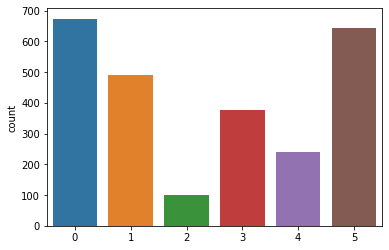

In [ ]:
import seaborn as sns
g = sns.countplot(data=df_train, x="Label")

## Step 5: Choose one of CNN models

### EfficientNet B0 to B7

__Model-EfficientNet__

https://pytorch.org/hub/nvidia_deeplearningexamples_efficientnet/

|  Base model | resolution  | Base model | resolution  |
|---|---|---|---|
| EfficientNetB0  | 224  | EfficientNetB4  | 380  |
| EfficientNetB1  | 240  | EfficientNetB5  | 456  |
| EfficientNetB2  | 260  | EfficientNetB6  | 528  |
| EfficientNetB3  | 300  | EfficientNetB7  | 600  |


In [ ]:
num_classes=6

In [ ]:
modelfile = None

In [ ]:
import torchvision.models as models
model=models.efficientnet_b3(num_classes=num_classes)
if modelfile != None: model.load_state_dict(torch.load(modelfile))
model.cuda()

## Step 6: Instancing a dataloader
* Transforms
* CustomDataset
* dataloader

In [ ]:
from torchvision import transforms
pretrained_size = 300
pretrained_means = [0.485, 0.456, 0.406]
pretrained_stds= [0.229, 0.224, 0.225]
train_transform = transforms.Compose([
    transforms.Resize(pretrained_size),
    transforms.RandomRotation(5),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomCrop(pretrained_size, padding = 10),
    transforms.ToTensor(),
    transforms.Normalize(mean = pretrained_means, std = pretrained_stds)
])

In [ ]:
from PIL import Image
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, csv_path, images_folder, transform = None):
        self.df = pd.read_csv(csv_path)
        self.images_folder = images_folder
        self.transform = transform

    def __len__(self):
        return len(self.df)
    def __getitem__(self, index):
        filename = self.df.iloc[index]['ID']
        label = self.df.iloc[index]['Label']
        image = Image.open(os.path.join(self.images_folder, filename)).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)
        return image, label

## Step 7: Set up a train dataloader with a custom dataset

In [ ]:
batches = 24
imgdir= "train_images"
csvfile = "train.csv"

In [ ]:
train_dataset = CustomDataset(csvfile, imgdir, train_transform)
train_dataloader = DataLoader(train_dataset,batch_size=batches, shuffle=True)
print(f"Total images={len(train_dataset)}")

Total images=2528


## Step 8: total_batch

In [ ]:
total_batch=len(train_dataset)//batches + 1
print(total_batch)

106


## Step 12: Train model

In [ ]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
num_epochs = 1

In [ ]:
for epoch in range(num_epochs):
  for i, (batch_images, batch_labels) in enumerate(train_dataloader):
    # Zero your gradients for every batch!
    optimizer.zero_grad()
    inputs = batch_images.cuda()
    labels = batch_labels.cuda()
    # Make predictions for this batch
    outputs  = model(inputs)

    # Compute the loss and its gradients
    cost = loss(outputs , labels)
    cost.backward()
    # Adjust learning weights
    optimizer.step()

    if (i+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], lter [{i+1}/{total_batch}] Loss: {cost.item():.4f}')

KeyboardInterrupt: ignored

## Step 14: Save the trained model

In [ ]:
outputfile = "AOI-EnB3.pth"
torch.save(model.state_dict(), outputfile)

## Step 15: Check training results

In [ ]:
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = pretrained_means, std = pretrained_stds)
])
batches =48

In [ ]:
test_dataset = CustomDataset(csvfile, imgdir, test_transform)
test_dataloader = DataLoader(test_dataset,batch_size=batches, shuffle=False)
print(f"Total images={len(test_dataset)}")

Total images=2528


In [ ]:
classes=[0,1,2,3,4,5]

In [ ]:
train_predictions = np.zeros(len(train_labels))

In [ ]:
model.eval()
# again no gradients needed
with torch.no_grad():
    total_batch = len(test_dataset)//batches
    for i, (batch_images, batch_labels) in enumerate(test_dataloader):
      images = batch_images.cuda()
      labels = batch_labels.cuda()
      outputs = model(images)
      _, predictions = torch.max(outputs, 1)
      train_predictions[i*batches:(i+1)*batches] = predictions.cpu()
      if (i+1) % 10 == 0:
          print(f'lter [{i+1}/{total_batch}]')

lter [10/52]
lter [20/52]
lter [30/52]
lter [40/52]
lter [50/52]


In [ ]:
train_predictions=train_predictions.astype(int)

In [ ]:
print(train_labels[:10])

[0 1 1 5 5 5 3 0 3 5]


In [ ]:
print(train_predictions[:10])

[0 1 3 1 5 5 0 0 0 5]


In [ ]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
# collect the correct predictions for each class
for label, prediction in zip(train_labels, train_predictions):
    if label == prediction:
        correct_pred[classes[label]] += 1
    total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname} is {accuracy:.1f} %')


Accuracy for class: 0 is 63.9 %
Accuracy for class: 1 is 48.0 %
Accuracy for class: 2 is 0.0 %
Accuracy for class: 3 is 29.4 %
Accuracy for class: 4 is 12.1 %
Accuracy for class: 5 is 66.3 %


## Step 16: Analyze training results


In [ ]:
from sklearn.metrics import confusion_matrix
confusion=confusion_matrix(train_labels, train_predictions)
print(confusion)

[[431  20   0  92   0 131]
 [ 34 236   0 113   0 109]
 [ 89   0   0   0   0  11]
 [206  38   0 111   3  20]
 [ 58  62   0  22  29  69]
 [  0  64   0 152   1 427]]


In [ ]:
train_num = 2528
overkill= []
underkill = []
for i,(label, prediction) in enumerate(zip(train_labels, train_predictions)):
  if label == 0 and prediction !=0:
    overkill.append(i)
  if label != 0 and prediction ==0:
    underkill.append(i)
print('# of overkill= {}; # of underkill= {} '.format(len(overkill), len(underkill)))

# of overkill= 243; # of underkill= 387 


## Step 17: Load the test set

In [ ]:
df_test = pd.read_csv("test.csv")
print(df_test.shape)

(10142, 2)


In [ ]:
df_test.head()

,ID,Label
0,test_00000.png,NaN
1,test_00001.png,NaN
2,test_00002.png,NaN
3,test_00003.png,NaN
4,test_00004.png,NaN


In [ ]:
test_files  = df_test.iloc[:,0].values
test_labels = df_test.iloc[:,1].values
print(test_labels[:10])

[nan nan nan nan nan nan nan nan nan nan]


## Step 18: Set up a test_dataloader with test_dataset

In [ ]:
imgdir= "test_images"
csvfile = "test.csv"

In [ ]:
test_dataset = CustomDataset(csvfile, imgdir, test_transform)
test_dataloader = DataLoader(test_dataset,batch_size=batches, shuffle=False)
print(f"Total images={len(test_dataset)}")

Total images=10142


In [ ]:
total_batch=len(test_dataset)//batches + 1
print(total_batch)

212


## Step 20: Check test results

In [ ]:
test_predictions = np.zeros(len(test_labels))

In [ ]:
model.eval()
# again no gradients needed
with torch.no_grad():
    total_batch = len(test_dataset)//batches
    for i, (batch_images, batch_labels) in enumerate(test_dataloader):
      images = batch_images.cuda()
      labels = batch_labels.cuda()
      outputs = model(images)
      _, predictions = torch.max(outputs, 1)
      test_predictions[i*batches:(i+1)*batches] = predictions.cpu()
      if (i+1) % 10 == 0:
          print(f'lter [{i+1}/{total_batch}]')

lter [10/211]
lter [20/211]
lter [30/211]
lter [40/211]
lter [50/211]
lter [60/211]
lter [70/211]
lter [80/211]
lter [90/211]
lter [100/211]
lter [110/211]
lter [120/211]
lter [130/211]
lter [140/211]
lter [150/211]
lter [160/211]
lter [170/211]
lter [180/211]
lter [190/211]
lter [200/211]
lter [210/211]


In [ ]:
test_predictions=test_predictions.astype(int)
test_predictions[:10]

## Step 21: Output test results

In [ ]:
df_out = pd.DataFrame(df_test)
df_out.shape

In [ ]:
df_out['Label'] = test_predictions
df_out.to_csv("pt-aoi-1216.csv", index=False)